In [2]:
import csv
import shapely
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np

#Load in the CSV Bike Station Location Data
df = pd.read_csv('../Data/HRSQ12020.csv')

#combine the latitude and longitude to make coordinates
df['coordinates'] = df[['Longitude', 'Latitude']].values.tolist()

# Change the coordinates to a geoPoint
df['coordinates'] = df['coordinates'].apply(Point)
df.head()

,Station #,Station Name,NumRacks,Latitude,Longitude,coordinates
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679,POINT (-80.004679 40.441326)
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080,POINT (-80.00308 40.440877)
2,1002,Third Ave & Wood St,15,40.439030,-80.001860,POINT (-80.00185999999999 40.43903)
3,1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375,POINT (-80.00037500000001 40.4372)
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102,POINT (-79.997102 40.435887)


In [3]:
#fixing wrong negative value for Latitude
df.loc[df["Latitude"] == df["Latitude"].min()]
df.at[80, 'Latitude'] = 40.467715

df.to_csv('../Data/bikes_station_location.csv', index=False)  

#count the number of racks at each station
rackTot = 0
for index, row in df.iterrows():
      rackTot += row['NumRacks']
print(rackTot)

1085


In [4]:
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
geobikes = gpd.GeoDataFrame(df, crs='EPSG:2956', geometry=geometry)
geobikes.head()

,Station #,Station Name,NumRacks,Latitude,Longitude,coordinates,geometry
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679,POINT (-80.004679 40.441326),POINT (-80.00468 40.44133)
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080,POINT (-80.00308 40.440877),POINT (-80.00308 40.44088)
2,1002,Third Ave & Wood St,15,40.439030,-80.001860,POINT (-80.00185999999999 40.43903),POINT (-80.00186 40.43903)
3,1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375,POINT (-80.00037500000001 40.4372),POINT (-80.00038 40.43720)
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102,POINT (-79.997102 40.435887),POINT (-79.99710 40.43589)


<AxesSubplot:>

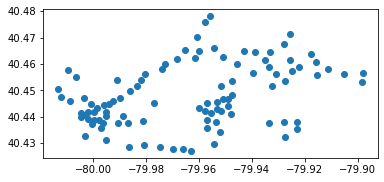

In [5]:
#plot the geodf
geobikes.plot()

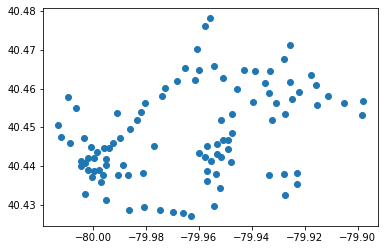

In [6]:
plt.scatter(df['Longitude'], df['Latitude'])
plt.show()

<AxesSubplot:>

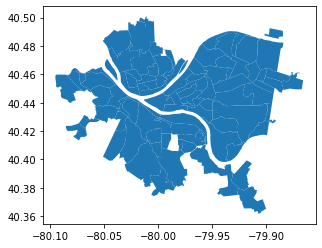

In [7]:
#Plot the Pittsburgh Neighborhoods
pittMap = gpd.read_file('../Data/Neighborhoods/ecc95d19-e9fb-46a3-be05-e7e103f362a52020328-1-565pof.jnegf.shp')
pittMap.plot()

<AxesSubplot:>

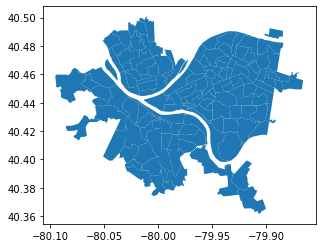

In [8]:
censusTract = gpd.read_file('../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
censusTract.plot()

In [46]:
# total area for the grid
xmin, ymin, xmax, ymax= censusTract.total_bounds

# how many cells across and down
n_cells=70
cell_size = (xmax-xmin)/n_cells
print(cell_size)
from pyproj import Proj
# projection of the grid
crs = "+proj=lcc +lat_1=40.96666666666667 +lat_2=39.93333333333333 +lat_0=39.33333333333334 +lon_0=-77.75 +x_0=600000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+(cell_size), cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)
map_points = gpd.GeoDataFrame()
cell["centroid"] = cell["geometry"].centroid
map_points["geometry"] = cell["geometry"].centroid

0.0032791346693956925


(-80.11042072408233, -79.85071325826598, 40.329868395427724, 40.5376343680808)

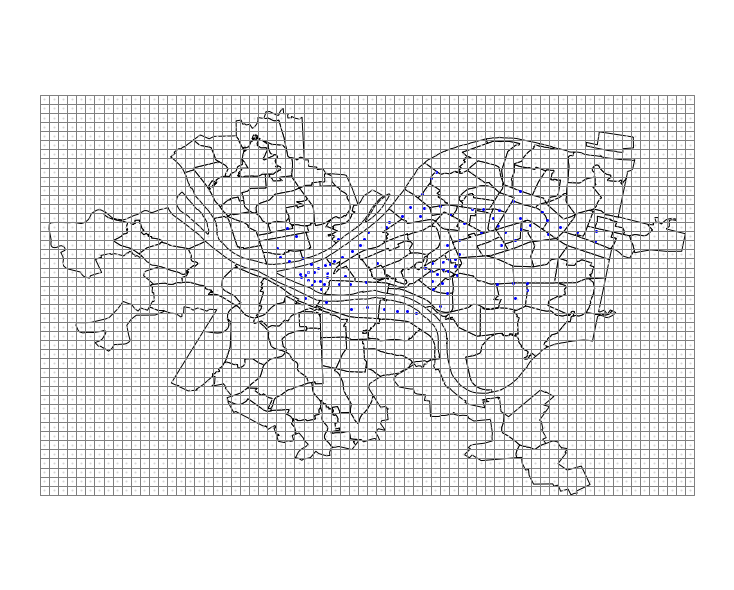

In [47]:
#Use matplotlib to plot the pittsburgh neighborhoods
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.set_position([0,0,1,1])   # Puts axis to edge of figure
lims = plt.axis('equal')
ax.set_aspect('equal')
censusTract.plot(ax = ax, color='white', edgecolor='black')
#geopandas plotting was not working, so I just plotted the scatter plot on top of the map for now...
#result = plt.scatter(df['Longitude'], df['Latitude'], 15, marker='o', color='Blue')
geobikes.plot(ax=ax, markersize=4, color='blue')
map_points.plot(ax=ax, markersize=1, color='lightgrey')
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis('off')

In [48]:
cell.head(1) #has four coordinate pairs

,geometry,centroid
0,"POLYGON ((-80.09862 40.36161, -80.09862 40.364...",POINT (-80.09698 40.36325)


In [32]:
map_points.head(1) #has one coordinate pair

,geometry
0,POINT (-80.09698 40.36325)


In [34]:
from pyproj import Proj
'''declare NAD83 State plane coordinate system for South Penn'''
p1 = Proj('+proj=lcc +lat_1=40.96666666666667 +lat_2=39.93333333333333 +lat_0=39.33333333333334 +lon_0=-77.75 +x_0=600000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs')
'''Test with sample latitude and longitude from Pittsburgh'''
sample_lat = 40.453372848142976
sample_long = -80.00290686110762
'''convert to state plane coordinates in meters'''
sp_lat, sp_long = p1(latitude=sample_lat, longitude=sample_long)
print('sp_lat = {}, sp_long = {}'.format(sp_lat, sp_long))
'''convert back to test'''
long, lat = p1(sp_lat, sp_long, inverse=True)
print('lat = {}, long = {}'.format(lat, long))

sp_lat = 408922.433628824, sp_long = 126801.0709187566
lat = 40.45337284814283, long = -80.00290686110762


In [37]:
cell['stations'] = 0

len(cell)

3168

In [38]:
len(map_points)

3168